In [1]:
# Importing the required packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

In [2]:
df_raw = pd.read_csv('sc_raw_data.csv')

In [3]:
# TEST
# df_raw = df_raw.head(3)

In [4]:
df_raw

,order_id,weight,travel_cost_plant1,travel_cost_plant2,return_cost_plant1,return_cost_plant2,production_time,unload_time,time_from_p1,time_from_p2,time_to_p1,time_to_p2
0,1,32,8,10,3,5,3,3,7,4,7,10
1,2,79,4,9,4,3,5,3,7,7,6,6
2,3,38,5,10,5,2,5,1,7,9,7,10
3,4,33,10,6,2,3,1,3,4,7,6,5
4,5,55,5,6,3,2,4,2,9,8,10,9
5,6,37,5,9,5,4,5,2,8,10,9,7
6,7,82,7,7,4,3,2,2,6,9,9,4
7,8,96,6,10,5,5,4,3,7,7,5,7
8,9,58,9,8,5,3,1,2,8,4,10,10
9,10,49,10,6,5,4,4,1,10,4,9,5


First we will need to produce a production schedule based on the order weights. This is important to understand which order has to be priortized.

In [5]:
# We start by creating tuples of orders for the production scheduling
orders = []
i = 0
for index, row in df_raw.iterrows():
    order = (row['order_id'], row['production_time'], row['weight'])
    orders.append(order)

In [6]:
print(orders)

[(1, 3, 32), (2, 5, 79), (3, 5, 38), (4, 1, 33), (5, 4, 55), (6, 5, 37), (7, 2, 82), (8, 4, 96), (9, 1, 58), (10, 4, 49)]


In [7]:
n = len(orders)
positions = range(n)

# Extract processing times and weights
TP = [order[1] for order in orders]
w = [order[2] for order in orders]

# Create a new model
m = gp.Model("weighted_completion_time")

# Create variables
x = m.addVars(n, n, vtype=GRB.BINARY, name="x")

# Objective function
completion_times = [sum(TP[j] * x[j, i] for j in positions) for i in positions]
weighted_completion_time = gp.quicksum(w[i] * completion_times[i] for i in positions)
m.setObjective(weighted_completion_time, GRB.MINIMIZE)

# Constraints
# Each order must be assigned to exactly one position
m.addConstrs((gp.quicksum(x[i, j] for j in positions) == 1 for i in positions), name="order_assigned")

# Each position must be assigned exactly one order
m.addConstrs((gp.quicksum(x[i, j] for i in positions) == 1 for j in positions), name="position_filled")

# Optimize model
m.optimize()

order_sequence = []
# Display the results
if m.status == GRB.OPTIMAL:
    print("Optimal total weighted completion time:", m.objVal)
    for j in positions:
        for i in positions:
            if x[i, j].x > 0.5:
                order_sequence.append((j+1,orders[i][0]))
                print(f"Order {orders[i][0]} is scheduled at position {j+1} with completion time {sum(TP[k] for k in range(j+1))}")
                #print(f"Order {orders[i][0]} is scheduled at position {j+1} with completion time {sum(TP[k] for k in range(j+1))}")

else:
    print("No optimal solution found.")

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 23.5.0 23F79)



CPU model: Intel(R) Core(TM) i7-8557U CPU @ 1.70GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 100 columns and 200 nonzeros
Model fingerprint: 0x688da88f
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1724.0000000
Presolve time: 0.00s
Presolved: 20 rows, 100 columns, 200 nonzeros
Variable types: 0 continuous, 100 integer (100 binary)

Root relaxation: objective 1.588000e+03, 34 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1588.0000000 1588.00000  0.00%     -    0s

Explored 1 nodes (34 simplex iterations) in 0.02 seconds (0.00 work units)
Thr

We will then create a dataframe using the new production schedule found above

In [8]:
df_ps = pd.DataFrame(order_sequence, columns=['position', 'order_id'])

In [9]:
df_ps

,position,order_id
0,1,2
1,2,7
2,3,5
3,4,3
4,5,10
5,6,6
6,7,4
7,8,9
8,9,1
9,10,8


Next we will merge the this new dataframe with our existing dataframe from the imported data. We will also do the following:
1. Reorder the columns in such a way that position comes first for the ease of visualization. 
2. We will sort the entire dataframe by the ascending order of the position. This way the most important and the most valued order comes first.

In [10]:
df_final= pd.merge(df_raw, df_ps, on='order_id')
df_final = df_final[['position'] + [x for x in df_raw.columns]]
df_final = df_final.sort_values(by='position', ascending=True).reset_index(drop=True)

In [11]:
df_final

,position,order_id,weight,travel_cost_plant1,travel_cost_plant2,return_cost_plant1,return_cost_plant2,production_time,unload_time,time_from_p1,time_from_p2,time_to_p1,time_to_p2
0,1,2,79,4,9,4,3,5,3,7,7,6,6
1,2,7,82,7,7,4,3,2,2,6,9,9,4
2,3,5,55,5,6,3,2,4,2,9,8,10,9
3,4,3,38,5,10,5,2,5,1,7,9,7,10
4,5,10,49,10,6,5,4,4,1,10,4,9,5
5,6,6,37,5,9,5,4,5,2,8,10,9,7
6,7,4,33,10,6,2,3,1,3,4,7,6,5
7,8,9,58,9,8,5,3,1,2,8,4,10,10
8,9,1,32,8,10,3,5,3,3,7,4,7,10
9,10,8,96,6,10,5,5,4,3,7,7,5,7


In [12]:
# Initialize the 's' and 'li1' columns
initial_1= 0
initial_2= 0
df_final['si1'] = initial_1
df_final['si2'] = initial_2
df_final['li1'] = df_final['si1'] + df_final['production_time']
df_final['li2'] = df_final['si2'] + df_final['production_time']
df_final['fi1'] = df_final['li1'] + df_final['unload_time'] + df_final['time_from_p1'] + df_final['time_to_p1']
df_final['fi2'] = df_final['li2'] + df_final['unload_time'] + df_final['time_from_p2'] + df_final['time_to_p2']

# Update the 's' and 'li1' values row by row
for i in range(1, len(df_final)):
    df_final.at[i, 'si1'] = df_final.at[i-1, 'fi1']
    df_final.at[i, 'si2'] = df_final.at[i-1, 'fi2']
    df_final.at[i, 'li1'] = df_final.at[i, 'si1'] + df_final.at[i, 'production_time']
    df_final.at[i, 'li2'] = df_final.at[i, 'si2'] + df_final.at[i, 'production_time']
    df_final.at[i, 'fi1'] = df_final.at[i, 'li1'] + df_final.at[i, 'unload_time'] + df_final.at[i, 'time_from_p1'] + df_final.at[i, 'time_to_p1'] 
    df_final.at[i, 'fi2'] = df_final.at[i, 'li2'] + df_final.at[i, 'unload_time'] + df_final.at[i, 'time_from_p2'] + df_final.at[i, 'time_to_p2'] 

In [13]:
df_final

,position,order_id,weight,travel_cost_plant1,travel_cost_plant2,return_cost_plant1,return_cost_plant2,production_time,unload_time,time_from_p1,time_from_p2,time_to_p1,time_to_p2,si1,si2,li1,li2,fi1,fi2
0,1,2,79,4,9,4,3,5,3,7,7,6,6,0,0,5,5,21,21
1,2,7,82,7,7,4,3,2,2,6,9,9,4,21,21,23,23,40,38
2,3,5,55,5,6,3,2,4,2,9,8,10,9,40,38,44,42,65,61
3,4,3,38,5,10,5,2,5,1,7,9,7,10,65,61,70,66,85,86
4,5,10,49,10,6,5,4,4,1,10,4,9,5,85,86,89,90,109,100
5,6,6,37,5,9,5,4,5,2,8,10,9,7,109,100,114,105,133,124
6,7,4,33,10,6,2,3,1,3,4,7,6,5,133,124,134,125,147,140
7,8,9,58,9,8,5,3,1,2,8,4,10,10,147,140,148,141,168,157
8,9,1,32,8,10,3,5,3,3,7,4,7,10,168,157,171,160,188,177
9,10,8,96,6,10,5,5,4,3,7,7,5,7,188,177,192,181,207,198


Now that we have set up the dataframe with due dates, we can extract the relevant data to set up our parameters.

In [44]:
# Set Up time
T = 100  # Example value, replace with actual number of time periods (cosider this as T+1)

In [45]:
# Define the number of orders, plants, and time periods
n = len(df_final)  # Example value, replace with actual number of orders
m = 2   # Example value, replace with actual number of plants
dik = [] # Example values for transportation costs from customer to plant
d0ik = []  # Example values for return transportation costs
li1 = [] # End of production for order i at plant 1
fi1 = [] # Vehicle returns to plant 1 after delivering order i
li2 = [] # End of production for order i at plant 2
fi2 = [] # Vehicle returns to plant 2 after delivering order i
wi = [] # Example values for profit weights for orders
for index, row in df_final.iterrows():
    forward_cost= [row['travel_cost_plant1'], row['travel_cost_plant2']]
    return_cost = [row['return_cost_plant1'], row['return_cost_plant2']]
    li1.append(row['li1'])
    li2.append(row['li2'])
    fi1.append(row['fi1'])
    fi2.append(row['fi2'])
    dik.append(forward_cost)
    d0ik.append(return_cost)
    wi.append(row['weight'])

# Parameters (these should be initialized with actual data)
vk = [1, 1]  # Example values for initial number of vehicles at each plant
Ck = [1, 1]  # Example values for production capacity of each plant
lik = li1+li2 # Example values for parameters associated with time of production end time in plant k (1,2)
fik = fi1+fi2 # Example values for parameters associated with time of vehicle return to a plant k (1,2)

We can now set up our mathematical model in gurobi for vehicle routing.

In [46]:
# Initialize model
model = gp.Model("Production_and_Delivery_Scheduling")

# Decision variables
x = model.addVars(n, m, vtype=GRB.BINARY, name="x")
z = model.addVars(n, m, vtype=GRB.BINARY, name="z")
y = model.addVars(T, m, vtype=GRB.INTEGER, name="y")

# Objective function
model.setObjective(
    gp.quicksum(wi[i] * x[i, k] for i in range(n) for k in range(m)) -
    gp.quicksum(dik[i][k] * x[i, k] for i in range(n) for k in range(m)) -
    gp.quicksum(d0ik[i][k] * z[i, k] for i in range(n) for k in range(m)),
    GRB.MAXIMIZE
)

# Constraints
# (1) An order can be processed in at most one plant
model.addConstrs((gp.quicksum(x[i, k] for k in range(m)) <= 1 for i in range(n)), "OrderProcessing")

# (2) After an order is served, the vehicle must return to a production plant
model.addConstrs((gp.quicksum(x[i, k] for k in range(m)) == gp.quicksum(z[i, k] for k in range(m)) for i in range(n)), "VehicleReturn")

# (3) Initial number of vehicles at each plant
model.addConstrs((y[0, k] == vk[k] for k in range(m)), "InitialVehicles")

# (4) Number of available vehicles at each plant in every instant t
model.addConstrs((
    y[t, k] == y[0, k] - gp.quicksum(x[i, k] for i in range(n) if lik[i] < t) + gp.quicksum(z[i, k] for i in range(n) if fik[i] <= t)
    for t in range(1,T) for k in range(m)), "AvailableVehicles")

# (5) An order i may be processed in plant k if there are available vehicles in instant lik
model.addConstrs((
    gp.quicksum(x[i, k] for i in range(n) if lik[i] == t) <= y[t, k]
    for t in range(1,T) for k in range(m)), "OrderProcessingAtPlant")

# (6) No more than Ck orders are assigned to any time period in any production plant
model.addConstrs((
    gp.quicksum(x[i, k] for i in range(n) if lik[i] == t) <= Ck[k]
    for t in range(1,T) for k in range(m)), "ProductionCapacity")

# Optimize model
model.optimize()

# Print the solution
for v in model.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective Value: {model.objVal}')

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 23.5.0 23F79)

CPU model: Intel(R) Core(TM) i7-8557U CPU @ 1.70GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 616 rows, 240 columns and 1582 nonzeros
Model fingerprint: 0x2dbc1c3f
Variable types: 0 continuous, 240 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 598 rows and 220 columns
Presolve time: 0.00s
Presolved: 18 rows, 20 columns, 78 nonzeros
Variable types: 0 continuous, 20 integer (20 binary)
Found heuristic solution: objective 465.0000000

Root relaxation: objective 4.660000e+02, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     

In [47]:
for o in range(n):    
    for p in range(m):
        # print(x[o,p])
        if x[o,p].x>0:
            print(f"Order {o} served by plant {p}")
        if z[o,p].x>0:
            print(f"Vehicle returns to plant {p} after serving order {o}")

Order 0 served by plant 0
Vehicle returns to plant 0 after serving order 0
Order 1 served by plant 1
Vehicle returns to plant 1 after serving order 1
Order 2 served by plant 1
Vehicle returns to plant 1 after serving order 2
Order 3 served by plant 0
Vehicle returns to plant 1 after serving order 3
Order 4 served by plant 1
Vehicle returns to plant 1 after serving order 4
Order 5 served by plant 0
Vehicle returns to plant 1 after serving order 5
Vehicle returns to plant 0 after serving order 6
Order 6 served by plant 1
Order 7 served by plant 1
Vehicle returns to plant 1 after serving order 7
Order 8 served by plant 0
Vehicle returns to plant 0 after serving order 8
Order 9 served by plant 0
Vehicle returns to plant 0 after serving order 9


In [48]:
p1 = []
p2 = []
time = []
for t in range(T):
    time.append(t)
    for p in range(m):
        if p == 0:
            p1.append(y[t,p].x)
        if p == 1:
            p2.append(y[t,p].x)

In [49]:
data = {
    'time':time,
    'plant_1':p1,
    'plant_2':p2
}
vehicle = pd.DataFrame(data)

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [51]:
vehicle.head(2)

,time,plant_1,plant_2
0,0,1.0,1.0
1,1,1.0,1.0


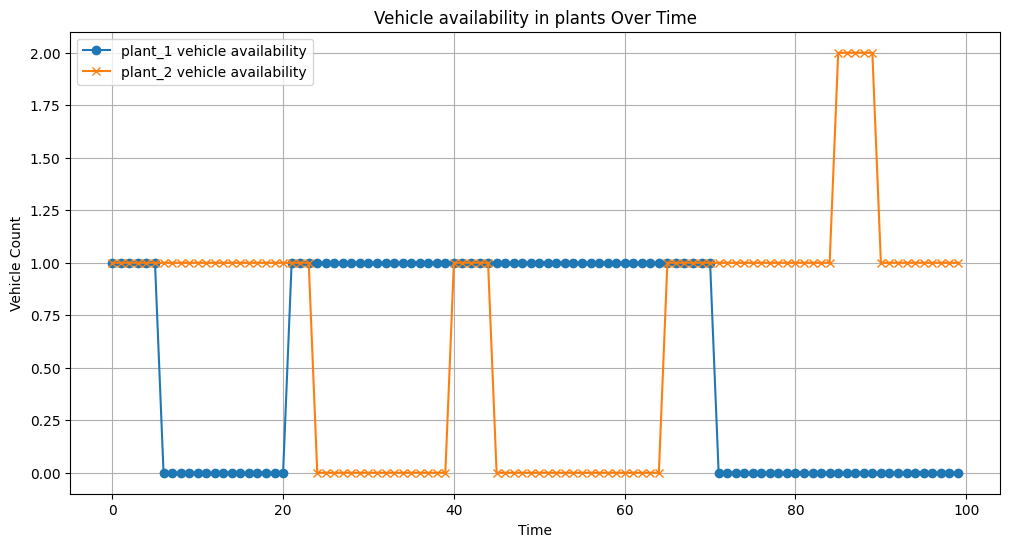

In [53]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(vehicle['time'], vehicle['plant_1'], label='plant_1 vehicle availability', marker='o')
plt.plot(vehicle['time'], vehicle['plant_2'], label='plant_2 vehicle availability', marker='x')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Vehicle Count')
plt.title('Vehicle availability in plants Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()